In [1]:
import numpy as np
import ROOT
from array import array

Welcome to JupyROOT 6.14/04


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
%matplotlib inline

In [4]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

In [5]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['font.size'] = 14

In [6]:
ROOT.gROOT.SetBatch(1)
ROOT.TH1.SetDefaultSumw2()

In [7]:
# interactive ROOT plots...but doesn't render anything on github :(
ROOT.enableJSVis()

This is an attempt at 2D unfolding, without backgrounds.

Let's generate some events. Each event will have the gen value, along with a corresponding reco value (smeared version of the gen value).

We create a function to generate a gen-level 2D distribution of "pt" and "mass", that are somehow correlated: (yes they're boring Gaussians)

In [8]:
def generate_truth_events(N):
    pt = np.random.normal(loc=25, scale=2, size=N)
    pt[pt<0] = 0
#     mass = np.random.normal(loc=(5*pt+10.*np.random.randn()), scale=2*(pt/10), size=N)
    mass = np.random.normal(loc=120, scale=5*(pt/10), size=N)
    mass[mass<0] = 0
    return pt, mass

In [9]:
pt_gen_values, mass_gen_values = generate_truth_events(100000)

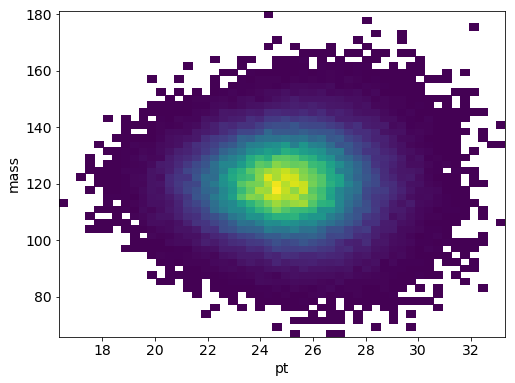

In [10]:
plt.hist2d(pt_gen_values, mass_gen_values, bins=[50, 50], cmin=0.0000001);
plt.xlabel("pt");
plt.ylabel("mass");

In [11]:
def smear(value, bias, width, only_positive=False):
    """Smear value according to Gaussian centered on each value with some bias, with a specified width"""
    values = np.random.normal(value, width)
    if only_positive:
        # use np.clip?
        values[values<0] = 0
    return values

In [12]:
pt_smear_width = 1.5
mass_smear_width = 5

In [13]:
pt_reco_values = smear(pt_gen_values, width=pt_smear_width, bias=0, only_positive=True)
mass_reco_values = smear(mass_gen_values, width=mass_smear_width, bias=0, only_positive=True)

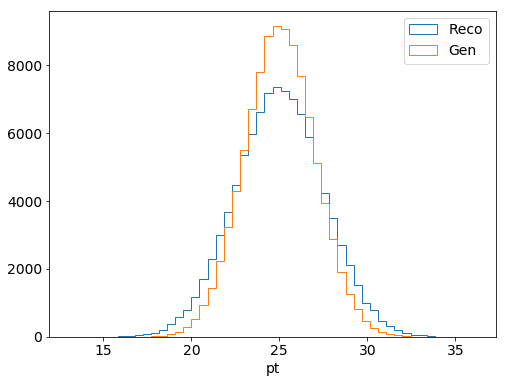

In [14]:
_, bins, _ = plt.hist(pt_reco_values, bins=50, histtype='step', label='Reco');
plt.hist(pt_gen_values, bins=bins, histtype='step', label='Gen');
plt.legend();
plt.xlabel('pt');

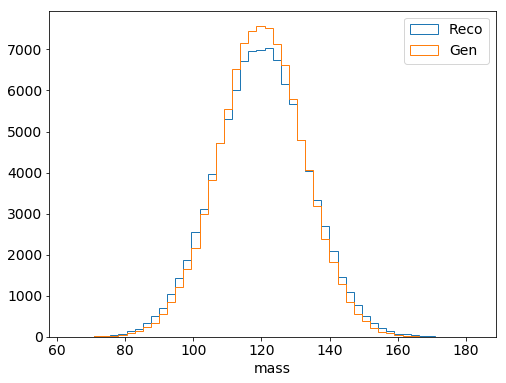

In [15]:
_, bins, _ = plt.hist(mass_reco_values, bins=50, histtype='step', label='Reco');
plt.hist(mass_gen_values, bins=bins, histtype='step', label='Gen');
plt.legend();
plt.xlabel('mass');

We now define binnings for our 2 variables. We need to ensure that we have empty under/overflow bins. The TUnfold method also recommends using at least double the number of reco bins as gen bins.

In [16]:
# define binning in gen & reco separately
# use arrays because that's all that PyROOT can handle
# use at least twice number of bins in reco as in gen
mass_max = 200
mass_min = 50
mass_gen_binning = array('d', np.linspace(mass_min, mass_max, 20))
mass_reco_binning = array('d', np.linspace(mass_min, mass_max, 40))

In [17]:
nbins_mass_gen = len(mass_gen_binning) - 1
nbins_mass_reco = len(mass_reco_binning) - 1

In [18]:
print("# gen mass bins:", nbins_mass_gen, "# reco mass bins:", nbins_mass_reco)

# gen mass bins: 19 # reco mass bins: 39


We can also plot the response matrix of reco vs gen using our binning:

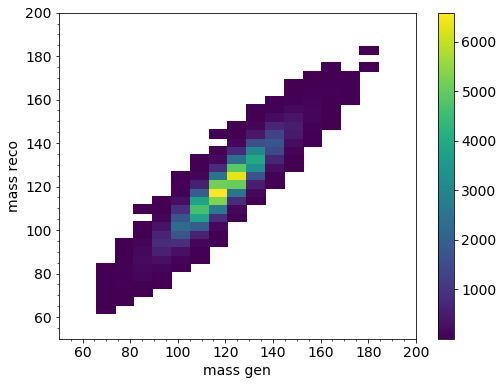

In [19]:
plt.hist2d(mass_gen_values, mass_reco_values, bins=[mass_gen_binning, mass_reco_binning], cmin=0.00001);
plt.xlabel("mass gen");
plt.ylabel("mass reco");
plt.colorbar();
plt.minorticks_on();

In [20]:
# define binning in gen & reco separately
# use arrays because that's all that PyROOT can handle
pt_gen_binning = array('d', np.arange(10, 50, 5))
pt_reco_binning = array('d', np.arange(0, 60, 2))

In [21]:
nbins_pt_gen = len(pt_gen_binning) - 1
nbins_pt_reco = len(pt_reco_binning) - 1

In [22]:
print("# gen bins:", nbins_pt_gen, "# reco bins:", nbins_pt_reco)

# gen bins: 7 # reco bins: 29


We can also plot the response matrix of reco vs gen using our binning:

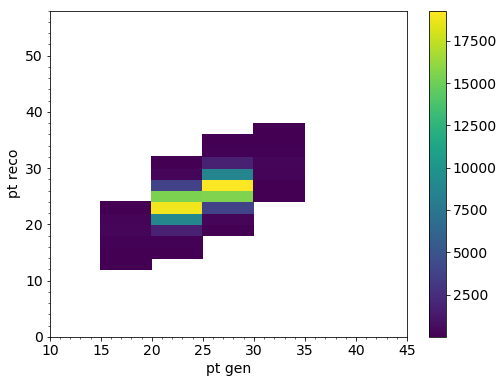

In [23]:
plt.hist2d(pt_gen_values, pt_reco_values, bins=[pt_gen_binning, pt_reco_binning], cmin=0.00001);
plt.xlabel("pt gen");
plt.ylabel("pt reco");
plt.colorbar();
plt.minorticks_on();

All the above values are our "signal" MC that we use to construct migration matrices

Let's now create a data distribution that we want to unfold, keeping both gen (truth) & reco (detector):

In [24]:
data_pt_gen_values, data_mass_gen_values = generate_truth_events(10000)
data_pt_reco_values = smear(data_pt_gen_values, width=pt_smear_width, bias=0, only_positive=True)
data_mass_reco_values = smear(data_mass_gen_values, width=mass_smear_width, bias=0, only_positive=True)

Let's visualise the 2D variable correlations at reco and gen:

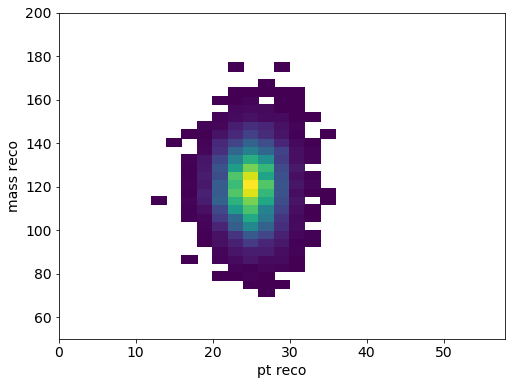

In [25]:
plt.hist2d(data_pt_reco_values, data_mass_reco_values, bins=[pt_reco_binning, mass_reco_binning], cmin=0.0001);
plt.xlabel('pt reco');
plt.ylabel('mass reco');

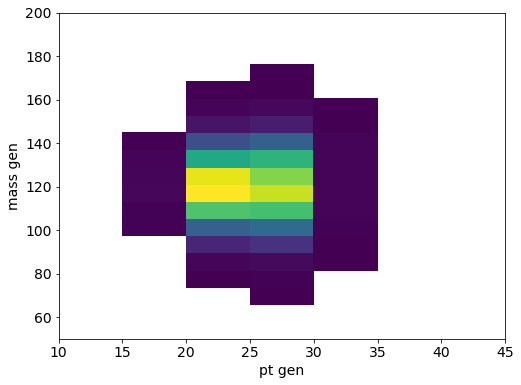

In [26]:
plt.hist2d(data_pt_gen_values, data_mass_gen_values, bins=[pt_gen_binning, mass_gen_binning], cmin=0.0001);
plt.xlabel('pt gen');
plt.ylabel('mass gen');

We now define our binning using TUnfoldBinning, which helps simplify "global" bin numbers etc. I'll call my variables "pt" and "mass", even though they don't look like them.

In [27]:
# Setup generator binning
# We only have "signal", no background
generator_binning = ROOT.TUnfoldBinning("generator")
signal_binning = generator_binning.AddBinning("signal")
signal_binning.AddAxis(
    "ptgen",
    nbins_pt_gen,
    pt_gen_binning,
    True, # underflow bin
    True # overflow bin
)
signal_binning.AddAxis(
    "massgen",
    nbins_mass_gen,
    mass_gen_binning,
    True, # underflow bin
    True # overflow bin
)

True

In [28]:
# Setup detector(reco) binning
reco_binning = ROOT.TUnfoldBinning("reco")
detector_binning = reco_binning.AddBinning("detector")
detector_binning.AddAxis(
    "pt",
    nbins_pt_reco,
    pt_reco_binning,
    False, # underflow bin
    True # overflow bin
)
detector_binning.AddAxis(
    "mass",
    nbins_mass_reco,
    mass_reco_binning,
    False, # underflow bin
    True # overflow bin
)

True

We now create all the correctly binned ROOT histograms: 1D for the various distributions, and a 2D migration matrix.

In [29]:
# Create histograms

# This hist will hold the data (reco) distributions
histDataReco = detector_binning.CreateHistogram("histDataReco");
# This will hold the data (gen) distributions, just for later comparison
histDataTruth = signal_binning.CreateHistogram("histDataTruth");
# This will hold MC (gen) distributions, again for comparison
histMCTruth = signal_binning.CreateHistogram("histMCTruth")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: creating converter for unknown type "int**"
  after removing the cwd from sys.path.


In [30]:
# Fill it with events
for pt, mass in zip(data_pt_reco_values, data_mass_reco_values):
    if mass > max(mass_reco_binning) or mass < min(mass_reco_binning):
        print("OUT OF RANGE:", mass)
    if pt > max(pt_reco_binning) or pt < min(pt_reco_binning):
        print("OUT OF RANGE:", pt)
    dataBin = detector_binning.GetGlobalBinNumber(pt, mass)  # if you use reco_binning here it will crash!
    histDataReco.Fill(dataBin)

In [31]:
for pt, mass in zip(data_pt_gen_values, data_mass_gen_values):
    dataBin = signal_binning.GetGlobalBinNumber(pt, mass)
    histDataTruth.Fill(dataBin)

In [32]:
for pt, mass in zip(pt_gen_values, mass_gen_values):
    mcbin = signal_binning.GetGlobalBinNumber(pt, mass)
    histMCTruth.Fill(mcbin)

In [33]:
c = ROOT.TCanvas()
histDataReco.Draw("HIST")
c.Draw()

In [34]:
c = ROOT.TCanvas()
# hst = ROOT.THStack()
# histMCTruth.SetLineColor(ROOT.kRed)
histDataTruth.Draw("HIST")
# # histMCTruth.Draw("HIST SAME")
# hst.Add(histDataTruth)
# hst.Add(histMCTruth)
# hst.Draw("HIST NOSTACK")
c.Draw()

In [35]:
c = ROOT.TCanvas()
histMCTruth.Draw("HIST")
c.Draw()

In [36]:
# 2D Histogram of migrations
histMCGenRec = ROOT.TUnfoldBinning.CreateHistogramOfMigrations(generator_binning, reco_binning, "histMCGenRec");

In [37]:
# Fill it with our "signal MC"
for ptGen, ptReco, massGen, massReco in zip(pt_gen_values, pt_reco_values, mass_gen_values, mass_reco_values):
    genBin = signal_binning.GetGlobalBinNumber(ptGen, massGen)
    recoBin = detector_binning.GetGlobalBinNumber(ptReco, massReco)
    histMCGenRec.Fill(genBin, recoBin)

In [38]:
c = ROOT.TCanvas()
histMCGenRec.Draw("COLZ")
c.Draw()

Now we have all our elements: our detector-level data to be unfolded, and our migration matrix from simulation. We set up our unfolder:

In [39]:
# kRegModeSize : regularise the amplitude of the output distribution
# kRegModeDerivative : regularize the 1st derivative of the output distribution
# kRegModeCurvature : regularize the 2st derivative of the output distribution
regularisation = ROOT.TUnfold.kRegModeCurvature

# kEConstraintNone : use no extra constraint
# kEConstraintArea : enforce preservation of the area
constraint = ROOT.TUnfold.kEConstraintArea

# kDensityModeNone : no scale factors, matrix L is similar to unity matrix
# kDensityModeBinWidth : scale factors from multidimensional bin width
# kDensityModeUser : scale factors from user function in TUnfoldBinning
# kDensityModeBinWidthAndUser : scale factors from multidimensional bin width and user function
density_mode = ROOT.TUnfoldDensity.kDensityModeBinWidth

# http://www.desy.de/~sschmitt/TUnfold/doxygen_17.6/html/classTUnfoldDensityV17.html#a2a54dcccb68d9305927939b4fa26490d
# name of the TUnfoldBinning node for which the regularisation conditions shall be set (zero matches all nodes)
# regularisation_distribution = ROOT.MakeNullPointer()
# regularisation_distribution = ROOT.MakeNullPointer(???)
# really this should be a blank char*
# but how the fuck do you create one in pyroot?
# None is not acceptable either

# "*[UOB]" uses bin widths to calculate derivatives but underflow/overflow bins are not regularized
regularisation_axis_steering = "*[B]"


unfolder = ROOT.TUnfoldDensity(
    histMCGenRec,  # migration matrix
    ROOT.TUnfold.kHistMapOutputHoriz,  # truth on x axis
    regularisation,
    constraint,
    density_mode,
    generator_binning,
    reco_binning,
#     regularisation_distribution,
#     regularisation_axis_steering
)

Info in <TUnfold::SetConstraint>: fConstraint=1
Warning in <TUnfold::TUnfold>: 138 output bins do not depend on the input data  0-30 33-39 43-47 52-56 61-65 70-74 79-83 88-92 97-101 106-110 115-119 124-128 133-138 142-147 151-156 159-190
Info in <TUnfold::TUnfold>: 1200 input bins and 53 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #1 (signal:massgen[ufl]:ptgen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #2 (signal:massgen[ufl]:ptgen[10,15])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #3 (signal:massgen[ufl]:ptgen[15,20])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #4 (signal:massgen[ufl]:ptgen[20,25])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #5 (signal:massgen[ufl]:ptgen[25,30])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #6 (signal:massgen[ufl]:ptgen[30,35])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #7 (signal:massgen[ufl]:ptgen[

In [42]:
%%cpp
cout << "This is a C++ cell" << endl;

This is a C++ cell


In [44]:
a = ROOT.A()

Constructor of A!


In [ ]:
%%cpp
TUnfold::EConstraint constraintMode = TUnfold::kEConstraintArea;

TUnfold::EHistMap histMap = TUnfold::kHistMapOutputHoriz;

TUnfold::ERegMode regMode = TUnfold::kRegModeCurvature;

TUnfoldDensity::EDensityMode densityFlags = TUnfoldDensity::kDensityModeBinWidth;

const char *REGULARISATION_DISTRIBUTION = 0;
const char *REGULARISATION_AXISSTEERING = "*[B]";

TUnfoldDensity unfold(
    histMCGenRec,
    histMap,
    regMode,
    constraintMode,
    densityFlags,
    generatorBinning,
    detectorBinning,
    REGULARISATION_DISTRIBUTION,
    REGULARISATION_AXISSTEERING);

cout << "Setup unfolder" << endl;


In [1]:
ROOT.unfold.SetInput(histDataReco)

NameError: name 'ROOT' is not defined

In [56]:
# define input to be unfolded
unfolder.SetInput(histDataReco)

SystemError: int TUnfoldSys::SetInput(const TH1* hist_y, double scaleBias = 0., double oneOverZeroError = 0., const TH2* hist_vyy = 0, const TH2* hist_vyy_inv = 0) =>
    problem in C++; program state has been reset

[/usr/lib/system/libsystem_platform.dylib] _sigtramp (no debug info)
[/usr/lib/system/libsystem_c.dylib] __sF (no debug info)
[/usr/local/Cellar/root/6.14.04_1/lib/root/libPyROOT.so] Cppyy::CallI(long, void*, void*) (no debug info)
[/usr/local/Cellar/root/6.14.04_1/lib/root/libPyROOT.so] PyROOT::TIntExecutor::Execute(long, void*, PyROOT::TCallContext*) (no debug info)
[/usr/local/Cellar/root/6.14.04_1/lib/root/libPyROOT.so] PyROOT::TMethodHolder::CallFast(void*, long, PyROOT::TCallContext*) (no debug info)
[/usr/local/Cellar/root/6.14.04_1/lib/root/libPyROOT.so] PyROOT::TMethodHolder::CallSafe(void*, long, PyROOT::TCallContext*) (no debug info)
[/usr/local/Cellar/root/6.14.04_1/lib/root/libPyROOT.so] PyROOT::TMethodHolder::Execute(void*, long, PyROOT::TCallContext*) (no debug info)
[/usr/local/Cellar/root/6.14.04_1/lib/root/libPyROOT.so] PyROOT::TMethodHolder::Call(PyROOT::ObjectProxy*&, _object*, _object*, PyROOT::TCallContext*) (no debug info)
[/usr/local/Cellar/root/6.14.04_1/lib/ro

Error in <TClingCallFunc::make_wrapper>: Failed to compile
  ==== SOURCE BEGIN ====
#pragma clang diagnostic push
#pragma clang diagnostic ignored "-Wformat-security"
__attribute__((used)) extern "C" void __cf_41(void* obj, int nargs, void** args, void* ret)
{
   if (nargs == 1) {
      if (ret) {
         new (ret) (int) (((TUnfoldSys*)obj)->SetInput(*(const TH1**)args[0]));
         return;
      }
      else {
         ((TUnfoldSys*)obj)->SetInput(*(const TH1**)args[0]);
         return;
      }
   }
   if (nargs == 2) {
      if (ret) {
         new (ret) (int) (((TUnfoldSys*)obj)->SetInput(*(const TH1**)args[0], *(double*)args[1]));
         return;
      }
      else {
         ((TUnfoldSys*)obj)->SetInput(*(const TH1**)args[0], *(double*)args[1]);
         return;
      }
   }
   if (nargs == 3) {
      if (ret) {
         new (ret) (int) (((TUnfoldSys*)obj)->SetInput(*(const TH1**)args[0], *(double*)args[1],
            *(double*)args[2]));
         return;
      }
      else {

We can also visualise our matrix of regularisation conditions:

Warning in <TROOT::Append>: Replacing existing TH1: h_L (Potential memory leak).


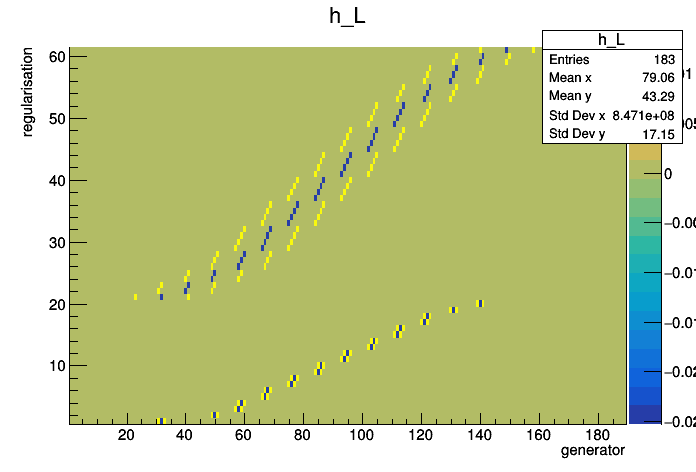

In [88]:
c = ROOT.TCanvas()
histL = unfolder.GetL("h_L")
histL.Draw("COLZ")
c.Draw()

We can now do a quick unfolding with a certain tau value:

In [89]:
unfolder.DoUnfold(0.1)

0.9580690908007085

Info in <TUnfoldDensity::InvertMSparseSymmPos>: cholesky-decomposition failed, try eigenvalue analysis
Warning in <TUnfoldDensity::DoUnfold>: rank of output covariance is 46 expect 50


In [90]:
# using *[UOB] seems to offset the whole thing
unfolded = unfolder.GetOutput("unfolded", "", "signal", "*[B]", False)

Warning in <TROOT::Append>: Replacing existing TH1: unfolded (Potential memory leak).


We can plot the truth vs unfolded - if all goes well they should ~agree:

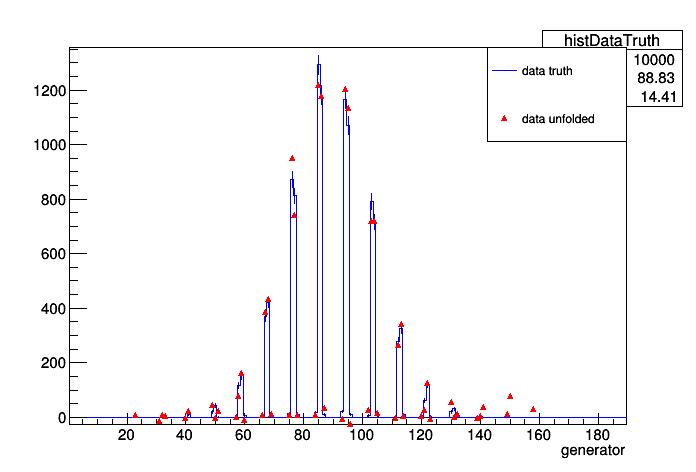

In [91]:
c = ROOT.TCanvas()

hst = ROOT.THStack("hst", "")
leg = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
# reco data for comparison
histDataReco.SetLineColor(ROOT.kBlack)
# hst.Add(histDataReco)

# truth of what data actually is
histDataTruth.SetLineColor(ROOT.kBlue)
hst.Add(histDataTruth)
leg.AddEntry(histDataTruth, 'data truth', 'LP')

# unfolded result
unfolded.SetLineColor(ROOT.kRed)
unfolded.SetLineWidth(0)
unfolded.SetMarkerColor(ROOT.kRed)
unfolded.SetMarkerStyle(22)
unfolded.SetMarkerSize(0.8)
hst.Add(unfolded)
leg.AddEntry(unfolded, 'data unfolded', 'LP')

hst.Draw("HIST NOSTACK")  # to get lines
hst.Draw("E NOSTACK SAME")  # to get error bars
hst.GetXaxis().SetTitle("generator")
leg.Draw()
c.Draw()


We now do the scan over tau to find the best value:

In [48]:
# number of points to scan over
n_scan = 100

# Graphs to save output from scan over tau
rho_log_tau = ROOT.MakeNullPointer(ROOT.TSpline)
l_curve = ROOT.MakeNullPointer(ROOT.TGraph)
Xspline = ROOT.MakeNullPointer(ROOT.TSpline)
Yspline = ROOT.MakeNullPointer(ROOT.TSpline)

tau_min, tau_max = 0., 0.  # let it decide range for us

# kEScanTauRhoAvg : average (stat+bgr) global correlation
# kEScanTauRhoSquaredAvg : average (stat+bgr) global correlation squared
# kEScanTauRhoMax : maximum (stat+bgr) global correlation
# kEScanTauRhoAvgSys : average (stat+bgr+sys) global correlation
# kEScanTauRhoAvgSquaredSys : average (stat+bgr+sys) global correlation squared
# kEScanTauRhoMaxSys : maximum (stat+bgr+sys) global correlation
scan_mode = ROOT.TUnfoldDensity.kEScanTauRhoAvg

# distribution for which the variable is to be calculated
distribution = "signal"

# http://www.desy.de/~sschmitt/TUnfold/doxygen_17.6/html/classTUnfoldDensityV17.html#a815afce9995271ae863afda3287bb078
# this should be a null ptr?
# but again, how the hell do you make one
steering_axis = "*[UO]"

In [122]:
# Run the unfolding and find the best tau by scanning correlation coefficients
i_best = unfolder.ScanTau(
    n_scan,
    tau_min,
    tau_max,
    rho_log_tau,  # save scanned function wrt log(tau)
    scan_mode,
    distribution,
#     steering_axis,
#     l_curve,  # save L curve
#     Xspline,  # save L-curve(X) as a function of log(tau)
#     Yspline   # save L-curve(Y) as a function of log(tau)
)

Warning in <TUnfoldDensity::DoUnfold>: rank of matrix E 47 expect 53
Warning in <TUnfoldDensity::DoUnfold>: rank of output covariance is 47 expect 53
Warning in <TUnfoldDensity::GetRhoIFormMatrix>: Covariance matrix has rank 47 expect 189
Info in <TUnfoldDensity::ScanTau>: logtau=-Infinity y=0.939676 X=2.168923 Y=3.258162
Info in <TUnfoldDensity::InvertMSparseSymmPos>: cholesky-decomposition failed, try eigenvalue analysis
Warning in <TUnfoldDensity::DoUnfold>: rank of output covariance is 48 expect 53
Info in <TUnfoldDensity::InvertMSparseSymmPos>: cholesky-decomposition failed, try eigenvalue analysis
Warning in <TUnfoldDensity::GetRhoIFormMatrix>: Covariance matrix has rank 48 expect 189
Info in <TUnfoldDensity::ScanTau>: logtau=-0.499031 y=0.914006 X=2.187568 Y=3.158503
Info in <TUnfoldDensity::InvertMSparseSymmPos>: cholesky-decomposition failed, try eigenvalue analysis
Warning in <TUnfoldDensity::DoUnfold>: rank of output covariance is 48 expect 53
Info in <TUnfoldDensity::Invert

In [123]:
c = ROOT.TCanvas()
rho_log_tau.Draw("ALP")
c.Draw()

In [124]:
c = ROOT.TCanvas()
l_curve.Draw("ALP")
c.Draw()

In [125]:
c = ROOT.TCanvas()
Xspline.Draw("ALP")
c.Draw()

In [126]:
c = ROOT.TCanvas()
Yspline.Draw("ALP")
c.Draw()